### Título de proyecto

"Prevención de enfermedades con ML"

### Tema

"Prevencion de ECV" 

Las enfermedades cardiovasculares (ECV) son la principal causa de muerte en todo el mundo y se cobran aproximadamente 17,9 millones de vidas cada año, lo que representa el 31 % de todas las muertes en todo el mundo. 
Este proyecto busca comparar diferentes métodos de ML hasta encontrar el mas eficiente en la deteccion de ECV's.
Poner la tecnología al servicio de la comunidad.

In [4]:
import pandas as pd
df=pd.read_csv("data/train.csv",sep=",")


In [5]:
df.drop("Unnamed: 0",axis=1,inplace=True)
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [6]:
#Comprobar que porcentaje de la variable target son 0(negativo)
((len(df[df["HeartDisease"]==0]))*100)/(len(df))

42.142857142857146

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             700 non-null    int64  
 1   Sex             700 non-null    object 
 2   ChestPainType   700 non-null    object 
 3   RestingBP       700 non-null    int64  
 4   Cholesterol     700 non-null    int64  
 5   FastingBS       700 non-null    int64  
 6   RestingECG      700 non-null    object 
 7   MaxHR           700 non-null    int64  
 8   ExerciseAngina  700 non-null    object 
 9   Oldpeak         700 non-null    float64
 10  ST_Slope        700 non-null    object 
 11  HeartDisease    700 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 65.8+ KB


Nuestro Dataframe esta relativamente balanceado.

Tenemos un Dataframe de 11 columnas y un target ("HeartDisease") sin valores nulos. Transformaremos las columnas de tipo "object" para ser tomadas por nuestro primer analisis y posteriores modelos.

In [8]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df["Sex"]=le.fit_transform(df["Sex"])
df["ChestPainType"]=le.fit_transform(df["ChestPainType"])
df["RestingECG"]=le.fit_transform(df["RestingECG"])
df["ExerciseAngina"]=le.fit_transform(df["ExerciseAngina"])
df["ST_Slope"]=le.fit_transform(df["ST_Slope"])



Analisis Univariante:

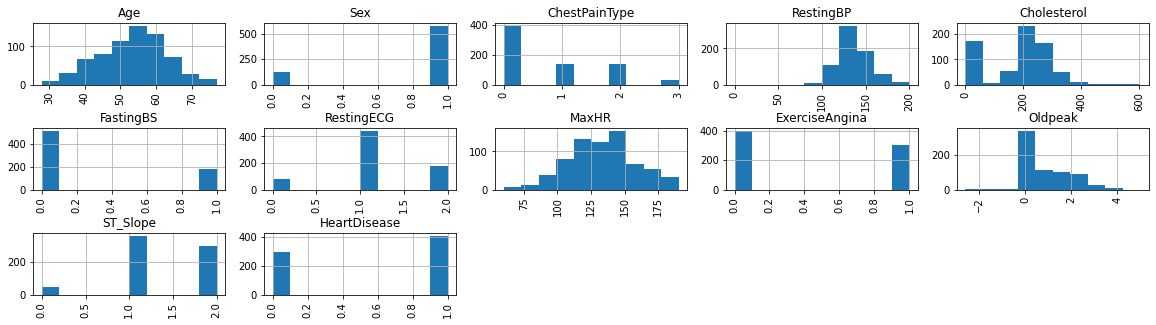

In [9]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(20, 5))
cols = 5
rows = int(np.ceil(float(df.shape[1]) / cols))
for i, column in enumerate(df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if df.dtypes[column] == object:
        df[column].value_counts().plot(kind="bar", axes=ax)
    else:
        df[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2);

Las variables tienen sentido y sus unidades de medida son correctas.
Puede que nuestro modelo se vea sesgado por sexo debido a que va a absorber muchos mas datos masculinos que femeninos.

Analisis Multivariante:

Puesto que tenemos pocas columnas podemos permitirnos realizar un pairplot para visualizar rapidamente como estan relacionadas las variables entre ellas y con la variable target

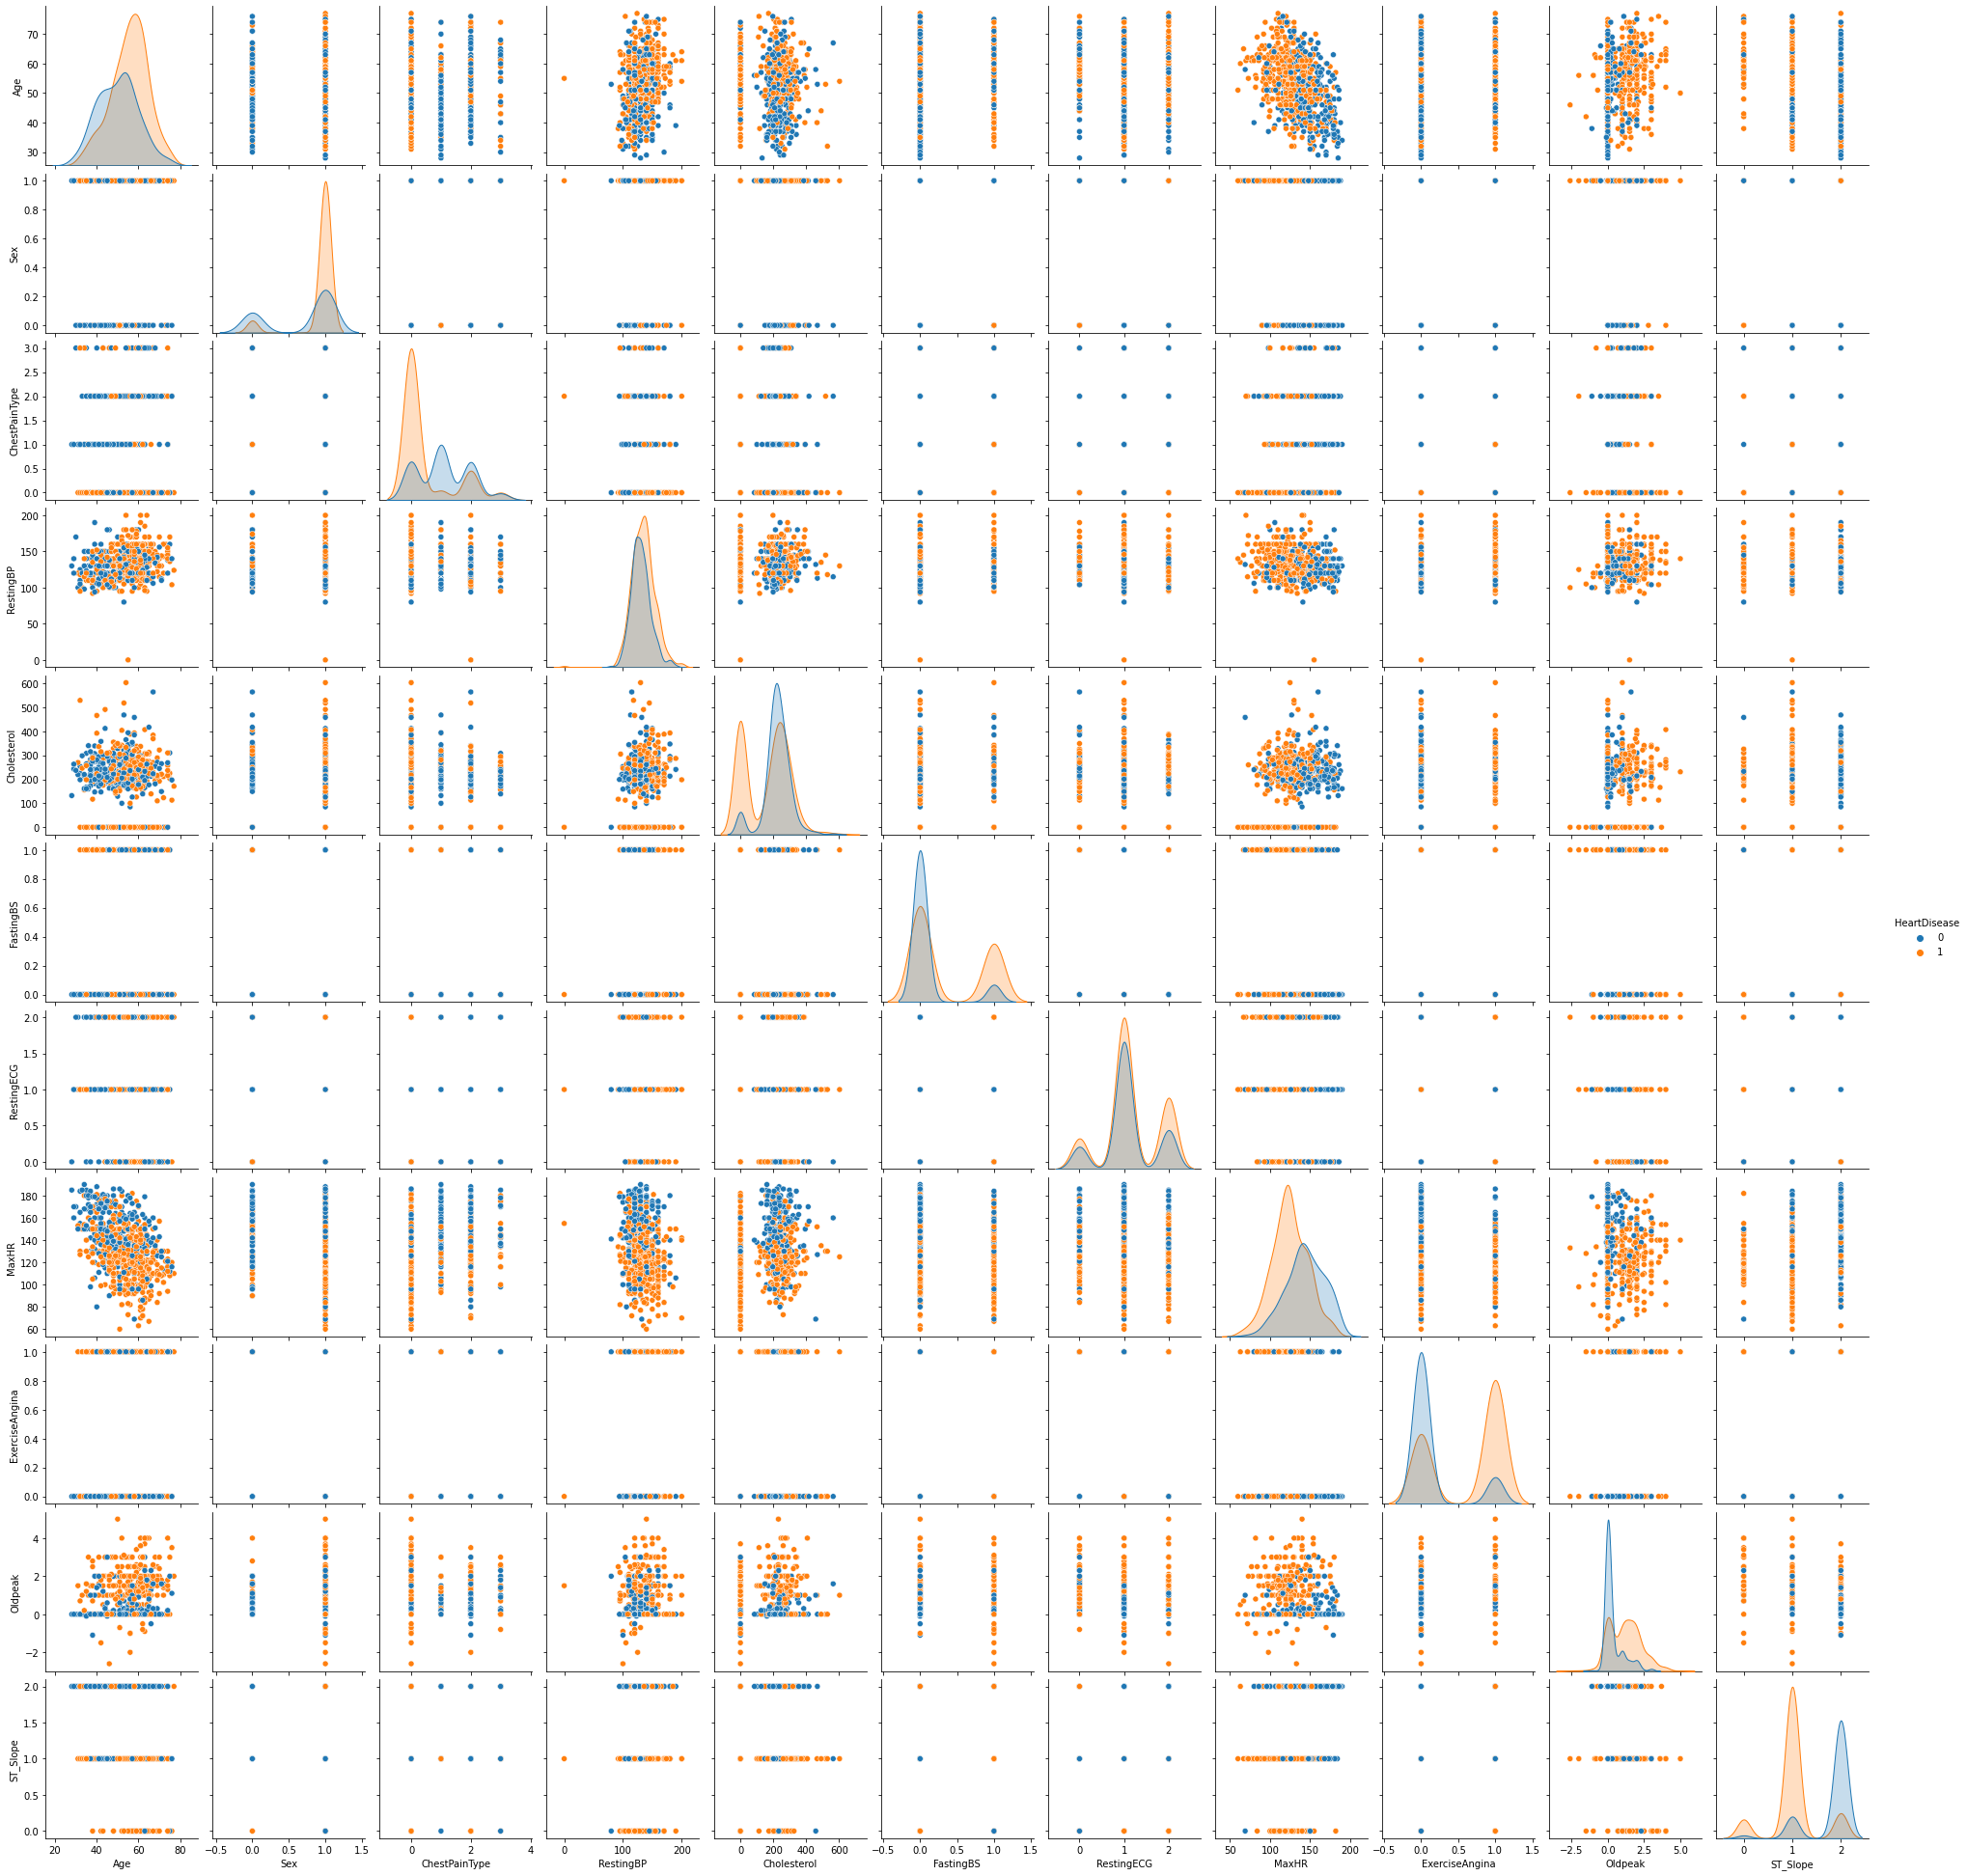

In [10]:
import seaborn as sns
sns.pairplot(df,
            kind='scatter',
            hue='HeartDisease');

Se ven claras diferencias visualmente. De primeras parece un problema a tratar con SVM

Para saber la correlación numérica de una forma visual haremos un mapa de calor intuitivo

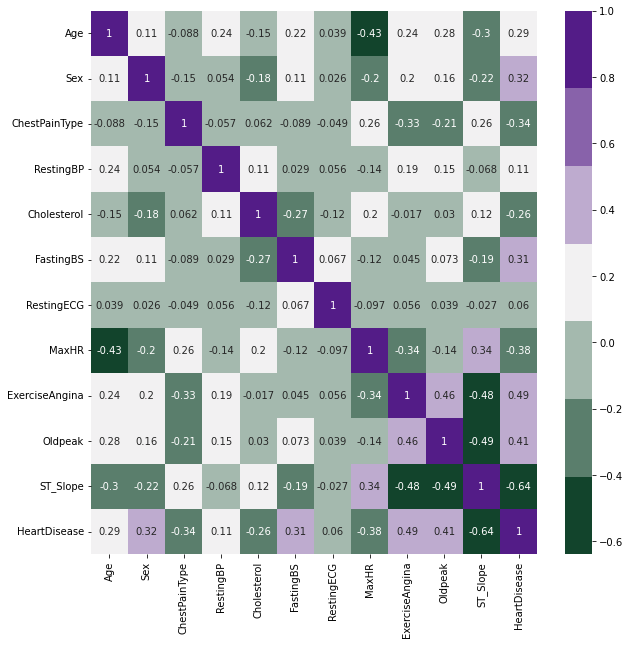

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),
           cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
           annot=True);

Vamos a realizar algunas transformaciones y a quedarnos con aquellas que mejoren la correlación con el target

In [12]:
import funciones3 as f
f.transformChest(df)
f.transformECG(df)
f.transformST(df)

Comprobamos si hemos mejorado las correlaciones

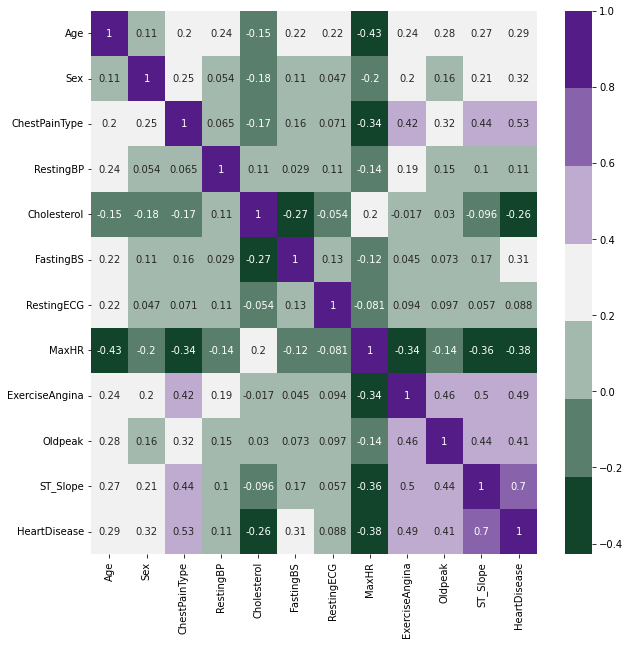

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),
           cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
           annot=True);

Para nuestros modelos eliminaremos "ExerciseAngina" por multicolinealidad

In [14]:
X = df.drop(["HeartDisease","ExerciseAngina"], axis=1)
y = df['HeartDisease'].copy()

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

Vamos a entrenar unos cuantos modelos de clasificación con Pipeline (donde utilizaremos PCA para omitir columnas sin varianza y StandardScaler en aquellos modelos que no sean arboles) que meteremos en un gridsearch con diferentes parámetros. Si queremos probar demasiados parámetros utilizaremos un RandomSearch.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost

xgb_clas = Pipeline([('pca', PCA()),
                    ("scaler",StandardScaler()),
                    ("xgboost",xgboost.XGBRFClassifier())
                   ])

gbct = GradientBoostingClassifier()


knn = Pipeline([    ('pca', PCA()),
                    ("scaler",StandardScaler()),
                    ("knn",KNeighborsClassifier())
                   ])

rand_forest = Pipeline([    ('pca', PCA()),
                            ('randf',RandomForestClassifier())
                            ])

svm = Pipeline([("scaler",StandardScaler()),
                ('pca', PCA()),
                ("selectkbest",SelectKBest()),
                ("svm",SVC())
               ])


reg_log = Pipeline([("scaler",StandardScaler()),
                    ("reglog",LogisticRegression())
                   ])

xgb_clas_param={     'pca__n_components': [5,6,7,8,9],
                    "xgboost__n_estimators": [80,90,100,110,120],
                     "xgboost__max_depth": [2,3,4,5,6],
                     "xgboost__learning_rate":[0.4,0.5,0.6,0.7,0.8,1,1.2,1.3]                        
                     }

rand_forest_param = {'pca__n_components': [5,6,7,8,9],
                    "randf__n_estimators": [100,110,120,140,150,160,200],
                     "randf__max_depth": [3,4,5,6,8,9,10,11,12,15,17],
                     "randf__max_features": ["sqrt", 3, 4]                          
                     }

gbct_param={        "n_estimators": [100,120,150],
                     "max_depth": [2,3,4,5,6],
                     "learning_rate":[0.8,1,1.3]                        
                     }

knn_param= {'pca__n_components': [3,4,5,6,7,8,9],
            "knn__n_neighbors":np.arange(1,500,2)}

svm_param = {
            'pca__n_components': [3,4,5,6,7,8,9],         
            'selectkbest__k': [1,2,3],
            'svm__C': [0.1,0.2, 0.4, 0.5, 0.6], 
            'svm__kernel': ["poly"],
            'svm__coef0': [-10.,-1., 0., 0.1, 0.5, 1,3, 5,10],
            'svm__gamma': ('scale', 'auto')
            }


reg_log_param = { 
                 "reglog__penalty": ["l1","l2"], 
                 "reglog__C": np.logspace(0, 2,4, 6,10)
                }


gs_rand_forestR = GridSearchCV(rand_forest,
                         rand_forest_param,
                         cv = 7,
                         scoring = 'recall',
                         verbose = 1,
                         n_jobs = -1)

gs_svmR = GridSearchCV(svm,
                         svm_param,
                         cv = 7,
                         scoring = 'recall',
                         verbose = 1,
                         n_jobs = -1)

gs_xgb_clasR = GridSearchCV(xgb_clas,
                         xgb_clas_param,
                         cv = 7,
                         scoring = 'recall',
                         verbose = 1,
                         n_jobs = -1)

gs_gbctR = GridSearchCV(gbct,
                         gbct_param,
                         cv = 7,
                         scoring = 'recall',
                         verbose = 1,
                         n_jobs = -1)

gs_knnR = RandomizedSearchCV(knn,
                         knn_param,
                         n_iter=150,
                         cv = 7,
                         scoring = 'recall',
                         verbose = 1,
                         n_jobs = -1)

grids = {
        "gs_rand_forest": gs_rand_forestR,
        "gs_knn":gs_knnR,
        "gs_gbct":gs_gbctR,
        "gs_xgb_clas":gs_xgb_clasR,
        "gs_svm": gs_svmR
        }

for nombre, grid_search in grids.items():
    grid_search.fit(X_train, y_train)

best_grids = [(i, j.best_score_) for i, j in grids.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

Fitting 7 folds for each of 1155 candidates, totalling 8085 fits
Fitting 7 folds for each of 150 candidates, totalling 1050 fits


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [0.91984127 0.96154401 1.         0.95829726 0.89090909 1.
 0.94227994 0.95836941 0.98722944 0.96479076 0.98088023 0.98405483
 1.         0.91630592 0.86854257 0.85584416 0.93268398 0.92936508
 0.93910534 0.88816739 0.95505051 0.96154401 1.         0.89437229
 1.         0.93910534 0.89718615 0.90685426 0.98080808 0.9968254
 0.91688312 0.93275613 0.94227994 0.93261183 0.93924964 0.96796537
        nan 0.91976912 0.94235209 0.9487013         nan        nan
 1.         1.         1.         0.94242424 0.9968254  0.96803752
 0.9487013  1.         0.91984127 0.93903319 0.92604618 0.92287157
 1.         0.92323232 0.87821068 0.9968254  0.94877345 1.
 0.92316017 0.97113997 0.96796537 0.99047619 0.9518759  0.91673882
 0.86529582 1.         0.99040404 0.90728716 0.92294372 0.92950938
 0.86536797        nan 0.94235209 0.91659

Fitting 7 folds for each of 45 candidates, totalling 315 fits
Fitting 7 folds for each of 1000 candidates, totalling 7000 fits


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:10:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 7 folds for each of 1890 candidates, totalling 13230 fits


Grid  Best score
1          gs_knn    1.000000
4          gs_svm    0.974531
0  gs_rand_forest    0.955195
3     gs_xgb_clas    0.952020
2         gs_gbct    0.910678

Esto son datos de entrenamiento bajo la metrica de recall, vamos a ver sobre la parte de test que nos habiamos reservado

In [18]:
from sklearn.metrics import accuracy_score,precision_score, recall_score
accuracy=[]
recall=[]
grids = {
        "gs_rand_forest": gs_rand_forestR,
        "gs_knn":gs_knnR,
        "gs_gbct":gs_gbctR,
        "gs_xgb_clas":gs_xgb_clasR,
        "gs_svm": gs_svmR
        }
        
for i in grids.values():
    preds = i.best_estimator_.predict(X_test)
    accuracy.append(accuracy_score(y_test, preds))
    recall.append(recall_score(y_test,preds))

best_predict=pd.DataFrame(grids.keys())
best_predict["recall"]=recall
best_predict["accuracy"]=accuracy
best_predict.sort_values(by="recall", ascending=False)



0    recall  accuracy
1          gs_knn  0.978261  0.821429
4          gs_svm  0.956522  0.828571
2         gs_gbct  0.923913  0.892857
0  gs_rand_forest  0.902174  0.885714
3     gs_xgb_clas  0.902174  0.871429

Desconfio que KNN se halla ajustado perfectamente a los datos de entrenamiento y después pierda tanta accuracy.Probablemente estemos ante un caso de Overfiting.Lo comprobaremos mas adelante prediciendo un conjunto de datos mayor como es el dataset "Test".

Vamos a hacer lo mismo que antes bajo la métrica de "accuracy" sin dejar de lado el "recall".

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost

xgb_clas = Pipeline([('pca', PCA()),
                    ("scaler",StandardScaler()),
                    ("xgboost",xgboost.XGBRFClassifier())
                   ])

gbct = GradientBoostingClassifier()


knn = Pipeline([    ('pca', PCA()),
                    ("scaler",StandardScaler()),
                    ("knn",KNeighborsClassifier())
                   ])

rand_forest = Pipeline([    ('pca', PCA()),
                            ('randf',RandomForestClassifier())
                            ])

svm = Pipeline([("scaler",StandardScaler()),
                ('pca', PCA()),
                ("selectkbest",SelectKBest()),
                ("svm",SVC())
               ])


reg_log = Pipeline([("scaler",StandardScaler()),
                    ("reglog",LogisticRegression())
                   ])

xgb_clas_param={     'pca__n_components': [5,6,7,8,9],
                    "xgboost__n_estimators": [80,90,100,110,120],
                     "xgboost__max_depth": [2,3,4,5,6],
                     "xgboost__learning_rate":[0.4,0.5,0.6,0.7,0.8,1,1.2,1.3]                        
                     }

rand_forest_param = {'pca__n_components': [5,6,7,8,9],
                    "randf__n_estimators": [100,110,120,140,150,160,200],
                     "randf__max_depth": [3,4,5,6,8,9,10,11,12,15,17],
                     "randf__max_features": ["sqrt", 3, 4]                          
                     }

gbct_param={        "n_estimators": [100,120,150],
                     "max_depth": [2,3,4,5,6],
                     "learning_rate":[0.8,1,1.3]                        
                     }

knn_param= {'pca__n_components': [3,4,5,6,7,8,9],
            "knn__n_neighbors":np.arange(1,500,2)}

svm_param = {
            'pca__n_components': [3,4,5,6,7,8,9],         
            'selectkbest__k': [1,2,3],
            'svm__C': [0.1,0.2, 0.4, 0.5, 0.6], 
            'svm__kernel': ["poly"],
            'svm__coef0': [-10.,-1., 0., 0.1, 0.5, 1,3, 5,10],
            'svm__gamma': ('scale', 'auto')
            }


reg_log_param = { 
                 "reglog__penalty": ["l1","l2"], 
                 "reglog__C": np.logspace(0, 2,4, 6,10)
                }


gs_rand_forest = GridSearchCV(rand_forest,
                         rand_forest_param,
                         cv = 7,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

gs_svm = GridSearchCV(svm,
                         svm_param,
                         cv = 7,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

gs_xgb_clas = GridSearchCV(xgb_clas,
                         xgb_clas_param,
                         cv = 7,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

gs_gbct = GridSearchCV(gbct,
                         gbct_param,
                         cv = 7,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

gs_knn = RandomizedSearchCV(knn,
                         knn_param,
                         n_iter=150,
                         cv = 7,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

grids = {
        "gs_rand_forest": gs_rand_forest,
        "gs_knn":gs_knn,
        "gs_gbct":gs_gbct,
        "gs_xgb_clas":gs_xgb_clas,
        "gs_svm": gs_svm
        }

for nombre, grid_search in grids.items():
    grid_search.fit(X_train, y_train)

best_grids = [(i, j.best_score_) for i, j in grids.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

Fitting 7 folds for each of 1155 candidates, totalling 8085 fits
Fitting 7 folds for each of 150 candidates, totalling 1050 fits


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [0.55892857 0.86607143 0.675      0.80357143 0.87142857 0.85178571
 0.86964286 0.88035714 0.75357143 0.86607143 0.87857143 0.72678571
 0.87857143 0.88214286 0.86071429 0.86785714 0.80714286 0.88214286
 0.87857143 0.55892857 0.87321429 0.86428571 0.86964286 0.85892857
 0.81785714 0.78571429 0.86071429 0.84107143 0.86964286 0.63214286
 0.81428571 0.68571429 0.80357143 0.85892857 0.575      0.55892857
 0.85              nan 0.55892857 0.80178571 0.55892857 0.8625
 0.83035714 0.74285714 0.83571429 0.87857143 0.85178571 0.55892857
 0.55892857 0.55892857 0.55892857 0.8        0.86071429 0.55892857
 0.55892857 0.7875     0.87857143 0.73571429 0.68571429 0.87857143
 0.86428571 0.86428571 0.88571429 0.85714286 0.55892857 0.55892857
 0.86607143 0.83928571 0.87321429 0.87857143 0.8625     0.86607143
 0.85892857 0.88392857      

Fitting 7 folds for each of 45 candidates, totalling 315 fits
Fitting 7 folds for each of 1000 candidates, totalling 7000 fits


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 7 folds for each of 1890 candidates, totalling 13230 fits


Grid  Best score
0  gs_rand_forest    0.901786
3     gs_xgb_clas    0.892857
1          gs_knn    0.885714
4          gs_svm    0.880357
2         gs_gbct    0.873214

Probamos con la parte de test reservada del dataset train:

In [20]:
accuracy=[]
recall=[]
grids = {
        "gs_rand_forest": gs_rand_forest,
        "gs_knn":gs_knn,
        "gs_gbct":gs_gbct,
        "gs_xgb_clas":gs_xgb_clas,
        "gs_svm": gs_svm
        }
        
for i in grids.values():
    preds = i.best_estimator_.predict(X_test)
    accuracy.append(accuracy_score(y_test, preds))
    recall.append(recall_score(y_test,preds))

best_predict=pd.DataFrame(grids.keys())
best_predict["recall"]=recall
best_predict["accuracy"]=accuracy
best_predict.sort_values(by="accuracy", ascending=False)

0    recall  accuracy
1          gs_knn  0.923913  0.900000
2         gs_gbct  0.934783  0.900000
4          gs_svm  0.923913  0.892857
0  gs_rand_forest  0.902174  0.878571
3     gs_xgb_clas  0.891304  0.871429

Vamos a probar la optimización con xgboost y Optuna (en base a "accuracy", ya que sino, he comprobado que se dedicaría a poner 1's)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 17)

In [22]:
def objective(trial, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val):
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dvalid = xgboost.DMatrix(X_val, label=y_val)

    param = {
        'objective' : 'binary:logistic',
        'base_score': trial.suggest_loguniform('base_score', 1e-3, 1),
        'colsample_bylevel': trial.suggest_loguniform('colsample_bylevel',1e-3, 1 ),
        'gamma': trial.suggest_categorical('gamma', [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.001,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6,0.7]),
        'n_estimators': trial.suggest_categorical('n_estimators', [50,80,100,150,200,300,400,500,800,900,1000,1100,1200,1500,1700,2000,2500,3000]),
        'max_depth': trial.suggest_categorical('max_depth', [3,4,5,6,7]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
    }


    model = xgboost.XGBRFClassifier(**param)    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)   
    preds = model.predict(X_val)
    rmse = accuracy_score(y_val, preds)

    return rmse

In [24]:
import optuna;

In [25]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)


trial = study.best_trial



params = []

for key, value in trial.params.items():
    params.append(value)
    print("    {}: {}".format(key, value))

[I 2022-04-16 01:32:11,788] A new study created in memory with name: no-name-009cd90f-3316-43ae-827a-c629c8da8707
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:11,881] Trial 0 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.002003943453066189, 'colsample_bylevel': 0.01346015811784646, 'gamma': 0.7, 'subsample': 0.3, 'learning_rate': 0.45, 'n_estimators': 400, 'max_depth': 5, 'min_child_weight': 11}. Best is trial 0 with value: 0.48214285714285715.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-pa

[01:32:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:12,039] Trial 2 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.011435331285911595, 'colsample_bylevel': 0.008695115162024446, 'gamma': 0.2, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 400, 'max_depth': 3, 'min_child_weight': 76}. Best is trial 0 with value: 0.48214285714285715.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:12,101] Trial 3 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.08696062836736575, 'colsample_bylevel': 0.7110408158610588, 'gamma'

[01:32:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:12,375] Trial 5 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.10661286024184839, 'colsample_bylevel': 0.032145668503445586, 'gamma': 0.8, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 1100, 'max_depth': 6, 'min_child_weight': 64}. Best is trial 0 with value: 0.48214285714285715.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:12,756] Trial 6 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.2784630229704187, 'colsample_bylevel': 0.07813578579406233, 'gamma'

[01:32:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:13,084] Trial 7 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.021043423888861833, 'colsample_bylevel': 0.002624629152299899, 'gamma': 0.4, 'subsample': 0.4, 'learning_rate': 0.3, 'n_estimators': 2500, 'max_depth': 4, 'min_child_weight': 72}. Best is trial 0 with value: 0.48214285714285715.


[01:32:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:13,184] Trial 8 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.013747041670133799, 'colsample_bylevel': 0.13511901564086026, 'gamma': 1.0, 'subsample': 0.9, 'learning_rate': 0.7, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 46}. Best is trial 0 with value: 0.48214285714285715.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be re

[01:32:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:13,502] Trial 11 finished with value: 0.5178571428571429 and parameters: {'base_score': 0.9379106077970861, 'colsample_bylevel': 0.31841184547267104, 'gamma': 0.5, 'subsample': 0.4, 'learning_rate': 0.15, 'n_estimators': 800, 'max_depth': 5, 'min_child_weight': 19}. Best is trial 11 with value: 0.5178571428571429.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be rem

[01:32:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:13,730] Trial 12 finished with value: 0.8125 and parameters: {'base_score': 0.9646125630985626, 'colsample_bylevel': 0.6347563690477567, 'gamma': 0.6, 'subsample': 0.3, 'learning_rate': 0.45, 'n_estimators': 800, 'max_depth': 5, 'min_child_weight': 1}. Best is trial 12 with value: 0.8125.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:13,911] Trial 13 finished with value: 0.8214285714285714 and parameters: {'base_score': 0.6081077711206188, 'colsample_bylevel': 0.7844878171553836, 'gamma': 0.6, 'subsample': 0.5, 'learn

[01:32:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:14,064] Trial 14 finished with value: 0.5178571428571429 and parameters: {'base_score': 0.6185637668453956, 'colsample_bylevel': 0.7591253449486004, 'gamma': 0.6, 'subsample': 0.5, 'learning_rate': 0.5, 'n_estimators': 800, 'max_depth': 5, 'min_child_weight': 32}. Best is trial 13 with value: 0.8214285714285714.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:14,250] Trial 15 finished with value: 0.75 and parameters: {'base_score': 0.39981645423535417, 'colsample_bylevel': 0.3521184003506277, 'gamma': 0.6, 'subsample': 

[01:32:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:14,846] Trial 16 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.3037264767717986, 'colsample_bylevel': 0.0010399146610221945, 'gamma': 0.6, 'subsample': 0.6, 'learning_rate': 0.25, 'n_estimators': 1700, 'max_depth': 5, 'min_child_weight': 2}. Best is trial 13 with value: 0.8214285714285714.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:15,051] Trial 17 finished with value: 0.5178571428571429 and parameters: {'base_score': 0.7698819357072361, 'colsample_bylevel': 0.9556848363186871, 'gamma': 

[01:32:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:15,357] Trial 19 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.0466006298189317, 'colsample_bylevel': 0.08229649520649518, 'gamma': 0.6, 'subsample': 0.5, 'learning_rate': 0.5, 'n_estimators': 1500, 'max_depth': 4, 'min_child_weight': 37}. Best is trial 13 with value: 0.8214285714285714.


[01:32:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:15,501] Trial 20 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.1630823187850448, 'colsample_bylevel': 0.3467463168413767, 'gamma': 1.0, 'subsample': 1.0, 'learning_rate': 0.2, 'n_estimators': 900, 'max_depth': 7, 'min_child_weight': 56}. Best is trial 13 with value: 0.8214285714285714.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be remo

[01:32:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:15,919] Trial 23 finished with value: 0.5178571428571429 and parameters: {'base_score': 0.9183719509817923, 'colsample_bylevel': 0.19306566771192807, 'gamma': 0.6, 'subsample': 0.5, 'learning_rate': 0.4, 'n_estimators': 800, 'max_depth': 4, 'min_child_weight': 23}. Best is trial 13 with value: 0.8214285714285714.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be remo

[01:32:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:16,310] Trial 24 finished with value: 0.8839285714285714 and parameters: {'base_score': 0.45835371805119685, 'colsample_bylevel': 0.4640381843635368, 'gamma': 0.4, 'subsample': 0.7, 'learning_rate': 0.4, 'n_estimators': 2000, 'max_depth': 6, 'min_child_weight': 36}. Best is trial 24 with value: 0.8839285714285714.


[01:32:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:16,499] Trial 25 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.1639347600852114, 'colsample_bylevel': 0.19784825555468072, 'gamma': 0.4, 'subsample': 0.7, 'learning_rate': 0.4, 'n_estimators': 1000, 'max_depth': 6, 'min_child_weight': 36}. Best is trial 24 with value: 0.8839285714285714.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be re

[01:32:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:16,792] Trial 26 finished with value: 0.5178571428571429 and parameters: {'base_score': 0.5716977778481391, 'colsample_bylevel': 0.06998903862411328, 'gamma': 0.4, 'subsample': 0.7, 'learning_rate': 0.45, 'n_estimators': 2000, 'max_depth': 6, 'min_child_weight': 52}. Best is trial 24 with value: 0.8839285714285714.


[01:32:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:17,137] Trial 27 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.29758083217414705, 'colsample_bylevel': 0.5411452052401007, 'gamma': 0.3, 'subsample': 0.6, 'learning_rate': 0.4, 'n_estimators': 2000, 'max_depth': 6, 'min_child_weight': 28}. Best is trial 24 with value: 0.8839285714285714.


[01:32:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:17,200] Trial 28 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.18806926544169505, 'colsample_bylevel': 0.19836615584279016, 'gamma': 0.9, 'subsample': 0.2, 'learning_rate': 0.4, 'n_estimators': 100, 'max_depth': 4, 'min_child_weight': 41}. Best is trial 24 with value: 0.8839285714285714.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be re

[01:32:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:17,573] Trial 30 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.003151145671568386, 'colsample_bylevel': 0.4326915962796418, 'gamma': 0.4, 'subsample': 0.5, 'learning_rate': 0.2, 'n_estimators': 300, 'max_depth': 6, 'min_child_weight': 12}. Best is trial 24 with value: 0.8839285714285714.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be re

[01:32:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:17,898] Trial 32 finished with value: 0.5178571428571429 and parameters: {'base_score': 0.5635520293932755, 'colsample_bylevel': 0.9397587833623838, 'gamma': 0.6, 'subsample': 0.3, 'learning_rate': 0.01, 'n_estimators': 800, 'max_depth': 5, 'min_child_weight': 28}. Best is trial 24 with value: 0.8839285714285714.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:18,182] Trial 33 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.4088615145947872, 'colsample_bylevel': 0.4949601323381903, 'gamma': 0.5

[01:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:18,443] Trial 34 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.07468010132967255, 'colsample_bylevel': 0.24137038000283084, 'gamma': 0.4, 'subsample': 0.7, 'learning_rate': 0.35, 'n_estimators': 1700, 'max_depth': 3, 'min_child_weight': 17}. Best is trial 24 with value: 0.8839285714285714.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be 

[01:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:18,694] Trial 36 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.11357931242344806, 'colsample_bylevel': 0.052110508582827786, 'gamma': 0.2, 'subsample': 0.3, 'learning_rate': 0.6, 'n_estimators': 1100, 'max_depth': 5, 'min_child_weight': 25}. Best is trial 24 with value: 0.8839285714285714.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be 

[01:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:19,040] Trial 37 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.27797450369338966, 'colsample_bylevel': 0.583273411485466, 'gamma': 0.8, 'subsample': 1.0, 'learning_rate': 0.05, 'n_estimators': 3000, 'max_depth': 3, 'min_child_weight': 59}. Best is trial 24 with value: 0.8839285714285714.


[01:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:19,532] Trial 38 finished with value: 0.5178571428571429 and parameters: {'base_score': 0.7695632504403966, 'colsample_bylevel': 0.13990252382247537, 'gamma': 0.7, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 2500, 'max_depth': 6, 'min_child_weight': 12}. Best is trial 24 with value: 0.8839285714285714.


[01:32:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:19,807] Trial 39 finished with value: 0.8928571428571429 and parameters: {'base_score': 0.12388231905608087, 'colsample_bylevel': 0.42641771345053714, 'gamma': 1.0, 'subsample': 0.5, 'learning_rate': 0.5, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 39 with value: 0.8928571428571429.


[01:32:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:19,919] Trial 40 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.1112180087538709, 'colsample_bylevel': 0.01923026292426833, 'gamma': 1.0, 'subsample': 0.5, 'learning_rate': 0.5, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 39}. Best is trial 39 with value: 0.8928571428571429.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be rem

[01:32:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:20,328] Trial 42 finished with value: 0.6964285714285714 and parameters: {'base_score': 0.232637656471243, 'colsample_bylevel': 0.22659865033440352, 'gamma': 0.9, 'subsample': 0.5, 'learning_rate': 0.5, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 11}. Best is trial 39 with value: 0.8928571428571429.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be remov


[01:32:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:20,496] Trial 43 finished with value: 0.9196428571428571 and parameters: {'base_score': 0.14592582375771884, 'colsample_bylevel': 0.39872747922688223, 'gamma': 1.0, 'subsample': 0.5, 'learning_rate': 0.5, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:20,686] Trial 44 finished with value: 0.9107142857142857 and parameters: {'base_score': 0.14579050381905764, 'colsample_bylevel': 0.2822457720013595, 'gamma': 1.0

[01:32:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:20,848] Trial 45 finished with value: 0.8928571428571429 and parameters: {'base_score': 0.13051647312707793, 'colsample_bylevel': 0.145071219143074, 'gamma': 1.0, 'subsample': 0.4, 'learning_rate': 0.5, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:20,987] Trial 46 finished with value: 0.5178571428571429 and parameters: {'base_score': 0.06460218034408456, 'colsample_bylevel': 0.14664921172600912, 'gamma': 1.0,

[01:32:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:21,242] Trial 48 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.023939204731917782, 'colsample_bylevel': 0.12078351921080874, 'gamma': 1.0, 'subsample': 0.4, 'learning_rate': 0.5, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be re

[01:32:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:21,524] Trial 50 finished with value: 0.5357142857142857 and parameters: {'base_score': 0.08456401711211442, 'colsample_bylevel': 0.28885397511231065, 'gamma': 1.0, 'subsample': 0.5, 'learning_rate': 0.7, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 4}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be remo

[01:32:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:21,707] Trial 51 finished with value: 0.875 and parameters: {'base_score': 0.15048785482380844, 'colsample_bylevel': 0.428854778539694, 'gamma': 1.0, 'subsample': 0.9, 'learning_rate': 0.5, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 8}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:21,844] Trial 52 finished with value: 0.7589285714285714 and parameters: {'base_score': 0.05047577152272336, 'colsample_bylevel': 0.3475452065680085, 'gamma': 1.0, 'subsample': 

[01:32:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:22,087] Trial 54 finished with value: 0.5625 and parameters: {'base_score': 0.25619791299648614, 'colsample_bylevel': 0.09518199800935917, 'gamma': 1.0, 'subsample': 0.5, 'learning_rate': 0.5, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 16}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a fu

[01:32:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:22,363] Trial 55 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.19515233121036973, 'colsample_bylevel': 0.0038092704181943446, 'gamma': 1.0, 'subsample': 0.6, 'learning_rate': 0.05, 'n_estimators': 900, 'max_depth': 7, 'min_child_weight': 9}. Best is trial 43 with value: 0.9196428571428571.


[01:32:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:22,570] Trial 56 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.33753144830887133, 'colsample_bylevel': 0.40763907081070166, 'gamma': 0.8, 'subsample': 0.5, 'learning_rate': 0.3, 'n_estimators': 1200, 'max_depth': 7, 'min_child_weight': 78}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be r

[01:32:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:23,047] Trial 58 finished with value: 0.6964285714285714 and parameters: {'base_score': 0.13435508496715112, 'colsample_bylevel': 0.04743229372862907, 'gamma': 0.5, 'subsample': 1.0, 'learning_rate': 0.35, 'n_estimators': 1500, 'max_depth': 7, 'min_child_weight': 4}. Best is trial 43 with value: 0.9196428571428571.


[01:32:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:23,106] Trial 59 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.05746696264590719, 'colsample_bylevel': 0.5160275568015081, 'gamma': 0.3, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 80, 'max_depth': 7, 'min_child_weight': 14}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be re

[01:32:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:23,602] Trial 61 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.15762184785035238, 'colsample_bylevel': 0.41710155770308427, 'gamma': 1.0, 'subsample': 0.9, 'learning_rate': 0.5, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 43 with value: 0.9196428571428571.


[01:32:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:24,187] Trial 62 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.1052362187707909, 'colsample_bylevel': 0.36111419310300835, 'gamma': 1.0, 'subsample': 0.9, 'learning_rate': 0.5, 'n_estimators': 1000, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:24,516] Trial 63 finished with value: 0.875 and parameters: {'base_score': 0.09867929631005112, 'colsample_bylevel': 0.34789954882107205, 'gamma': 1.0, 'subsample

[01:32:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:24,838] Trial 64 finished with value: 0.8125 and parameters: {'base_score': 0.07128282400982981, 'colsample_bylevel': 0.24549720181765392, 'gamma': 1.0, 'subsample': 0.9, 'learning_rate': 0.5, 'n_estimators': 1000, 'max_depth': 7, 'min_child_weight': 2}. Best is trial 43 with value: 0.9196428571428571.


[01:32:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:25,179] Trial 65 finished with value: 0.8839285714285714 and parameters: {'base_score': 0.12898521331950377, 'colsample_bylevel': 0.6945997914471203, 'gamma': 1.0, 'subsample': 0.9, 'learning_rate': 0.5, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 43 with value: 0.9196428571428571.


[01:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:25,259] Trial 66 finished with value: 0.9107142857142857 and parameters: {'base_score': 0.16507733541728184, 'colsample_bylevel': 0.3175267786649384, 'gamma': 1.0, 'subsample': 0.9, 'learning_rate': 0.5, 'n_estimators': 100, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be remov

[01:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:25,517] Trial 69 finished with value: 0.875 and parameters: {'base_score': 0.3544387131855161, 'colsample_bylevel': 0.30214771719569233, 'gamma': 1.0, 'subsample': 0.9, 'learning_rate': 0.7, 'n_estimators': 100, 'max_depth': 7, 'min_child_weight': 10}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a futu

[01:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:25,718] Trial 71 finished with value: 0.875 and parameters: {'base_score': 0.2370032003614746, 'colsample_bylevel': 0.3872312631828281, 'gamma': 1.0, 'subsample': 0.9, 'learning_rate': 0.7, 'n_estimators': 100, 'max_depth': 7, 'min_child_weight': 15}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a futur

[01:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:26,086] Trial 73 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.3038876661319918, 'colsample_bylevel': 0.23173466349195007, 'gamma': 1.0, 'subsample': 0.9, 'learning_rate': 0.2, 'n_estimators': 1000, 'max_depth': 7, 'min_child_weight': 18}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:26,165] Trial 74 finished with value: 0.8928571428571429 and parameters: {'base_score': 0.20986102299705736, 'colsample_bylevel': 0.2982179468024688, 'gamma': 1

[01:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:26,245] Trial 75 finished with value: 0.8303571428571429 and parameters: {'base_score': 0.10248968888444207, 'colsample_bylevel': 0.6449917857250081, 'gamma': 1.0, 'subsample': 0.9, 'learning_rate': 0.6, 'n_estimators': 150, 'max_depth': 7, 'min_child_weight': 11}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be remo

[01:32:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:26,479] Trial 77 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.12085436010153876, 'colsample_bylevel': 0.4767363613533473, 'gamma': 0.3, 'subsample': 0.2, 'learning_rate': 0.5, 'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 8}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:26,887] Trial 78 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.1544543613409438, 'colsample_bylevel': 0.38001378710759437, 'gamma': 0.

[01:32:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:27,074] Trial 79 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.0869961692338572, 'colsample_bylevel': 0.1839308371602339, 'gamma': 0.8, 'subsample': 0.4, 'learning_rate': 0.5, 'n_estimators': 1100, 'max_depth': 7, 'min_child_weight': 14}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be rem

[01:32:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:27,515] Trial 80 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.14862728737442207, 'colsample_bylevel': 0.11984287071342692, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 1700, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 43 with value: 0.9196428571428571.


[01:32:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:28,074] Trial 81 finished with value: 0.9107142857142857 and parameters: {'base_score': 0.26068439941157573, 'colsample_bylevel': 0.07860750691961425, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 1700, 'max_depth': 7, 'min_child_weight': 4}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:28,560] Trial 82 finished with value: 0.8928571428571429 and parameters: {'base_score': 0.18594596444956452, 'colsample_bylevel': 0.06968237881501411, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 1700, 'max_depth': 7, 'min_child_weight': 5}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:29,118] Trial 83 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.2735463146500984, 'colsample_bylevel': 0.21669345520234615, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 11}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:29,647] Trial 84 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.22161129367692256, 'colsample_bylevel': 0.10865406566513058, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 11}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:30,009] Trial 85 finished with value: 0.5178571428571429 and parameters: {'base_score': 0.4769193713497591, 'colsample_bylevel': 0.11646618521844974, 'gamma': 0

[01:32:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:30,536] Trial 86 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.2588829776961609, 'colsample_bylevel': 0.03059761495404849, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 12}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:30,905] Trial 87 finished with value: 0.8660714285714286 and parameters: {'base_score': 0.14929126442336252, 'colsample_bylevel': 0.09445271165150299, 'gamma': 1

[01:32:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:31,404] Trial 88 finished with value: 0.875 and parameters: {'base_score': 0.265715179269223, 'colsample_bylevel': 0.03902729512274831, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 13}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:31,982] Trial 89 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.39637589526550815, 'colsample_bylevel': 0.02637373583374955, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 12}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:32,396] Trial 90 finished with value: 0.7410714285714286 and parameters: {'base_score': 0.5192664864989217, 'colsample_bylevel': 0.0248692417546313, 'gamma': 0.

[01:32:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:32,956] Trial 91 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.3554592388536709, 'colsample_bylevel': 0.026241222581729656, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 12}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:33,517] Trial 92 finished with value: 0.7678571428571429 and parameters: {'base_score': 0.7019473089972272, 'colsample_bylevel': 0.01521191611385462, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 11}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:34,036] Trial 93 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.36508294510621525, 'colsample_bylevel': 0.026695085416954555, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 15}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:34,623] Trial 94 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.2823454485793264, 'colsample_bylevel': 0.009938370503404022, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.05, 'n_estimators': 1700, 'max_depth': 7, 'min_child_weight': 4}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:35,281] Trial 95 finished with value: 0.8928571428571429 and parameters: {'base_score': 0.39630930857306623, 'colsample_bylevel': 0.06206506458823525, 'gamma': 0.9, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 8}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:35,706] Trial 96 finished with value: 0.5892857142857143 and parameters: {'base_score': 0.6837227774771079, 'colsample_bylevel': 0.033843454292958645, 'gamma': 1

[01:32:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:35,973] Trial 97 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.18509992937939626, 'colsample_bylevel': 0.053615816778462985, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.3, 'n_estimators': 1700, 'max_depth': 6, 'min_child_weight': 47}. Best is trial 43 with value: 0.9196428571428571.


[01:32:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:36,037] Trial 98 finished with value: 0.8392857142857143 and parameters: {'base_score': 0.23106650644936405, 'colsample_bylevel': 0.0979046110282172, 'gamma': 1.0, 'subsample': 1.0, 'learning_rate': 0.45, 'n_estimators': 50, 'max_depth': 7, 'min_child_weight': 3}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be remov

[01:32:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:36,694] Trial 100 finished with value: 0.8839285714285714 and parameters: {'base_score': 0.3137746332658256, 'colsample_bylevel': 0.02362433373190212, 'gamma': 0.5, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 19}. Best is trial 43 with value: 0.9196428571428571.


[01:32:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:36,809] Trial 101 finished with value: 0.7410714285714286 and parameters: {'base_score': 0.37031950536337677, 'colsample_bylevel': 0.03002284964050787, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.35, 'n_estimators': 200, 'max_depth': 7, 'min_child_weight': 7}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be re

[01:32:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:37,347] Trial 103 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.14255924693873423, 'colsample_bylevel': 0.15860481932364956, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.2, 'n_estimators': 1500, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 43 with value: 0.9196428571428571.


[01:32:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:37,632] Trial 104 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.0028013724916242265, 'colsample_bylevel': 0.12782335164592087, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 1700, 'max_depth': 7, 'min_child_weight': 10}. Best is trial 43 with value: 0.9196428571428571.


[01:32:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:38,276] Trial 105 finished with value: 0.8392857142857143 and parameters: {'base_score': 0.5099943800232644, 'colsample_bylevel': 0.019177511074213976, 'gamma': 0.3, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:38,934] Trial 106 finished with value: 0.9107142857142857 and parameters: {'base_score': 0.24845363153553915, 'colsample_bylevel': 0.04366259745050711, 'gamma': 0.8, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 12}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:39,289] Trial 107 finished with value: 0.8660714285714286 and parameters: {'base_score': 0.17543016399380545, 'colsample_bylevel': 0.040988678501010886, 'gamma

[01:32:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:39,830] Trial 108 finished with value: 0.8392857142857143 and parameters: {'base_score': 0.26039536906050476, 'colsample_bylevel': 0.016292158817853616, 'gamma': 0.7, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 25}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:39,914] Trial 109 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.15267565019303894, 'colsample_bylevel': 0.035979423479668836, 'gam

[01:32:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:40,548] Trial 110 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.20191509380434552, 'colsample_bylevel': 0.04630877719086007, 'gamma': 0.8, 'subsample': 1.0, 'learning_rate': 0.25, 'n_estimators': 1000, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:40,739] Trial 111 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.22878967131106961, 'colsample_bylevel': 0.021657357280759494, 'gamm

[01:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:40,915] Trial 112 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.23816344024002895, 'colsample_bylevel': 0.20711604075997966, 'gamma': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'n_estimators': 300, 'max_depth': 7, 'min_child_weight': 5}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:41,650] Trial 113 finished with value: 0.8928571428571429 and parameters: {'base_score': 0.3749576915961346, 'colsample_bylevel': 0.02584040735428565, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 13}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:41,983] Trial 114 finished with value: 0.8839285714285714 and parameters: {'base_score': 0.3097525045214015, 'colsample_bylevel': 0.022098630363497438, 'gamma':

[01:32:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:42,535] Trial 115 finished with value: 0.7946428571428571 and parameters: {'base_score': 0.11917352963889312, 'colsample_bylevel': 0.030218360455636074, 'gamma': 1.0, 'subsample': 0.9, 'learning_rate': 0.6, 'n_estimators': 2000, 'max_depth': 7, 'min_child_weight': 9}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:42,863] Trial 116 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.013239953870875827, 'colsample_bylevel': 0.062497729033687284, 'gam

[01:32:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:43,120] Trial 117 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.00651298499191484, 'colsample_bylevel': 0.08928687545255891, 'gamma': 0.2, 'subsample': 0.5, 'learning_rate': 0.45, 'n_estimators': 1100, 'max_depth': 6, 'min_child_weight': 15}. Best is trial 43 with value: 0.9196428571428571.


[01:32:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:43,902] Trial 118 finished with value: 0.8125 and parameters: {'base_score': 0.575147364346634, 'colsample_bylevel': 0.11627808670891207, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 3, 'min_child_weight': 10}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:44,601] Trial 119 finished with value: 0.9107142857142857 and parameters: {'base_score': 0.33989173705886516, 'colsample_bylevel': 0.014382322389657629, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 12}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:45,294] Trial 120 finished with value: 0.6875 and parameters: {'base_score': 0.2849644282814566, 'colsample_bylevel': 0.010922244365534005, 'gamma': 1.0, 'subsample': 0.9, 'learning_rate': 0.5, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 20}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:45,421] Trial 121 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.0011869225245807482, 'colsample_bylevel': 0.012442755287134491, 'gamma': 1.0, '

[01:32:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:46,729] Trial 122 finished with value: 0.8928571428571429 and parameters: {'base_score': 0.4241058172671131, 'colsample_bylevel': 0.01583981712326205, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 3000, 'max_depth': 7, 'min_child_weight': 5}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:47,002] Trial 123 finished with value: 0.5267857142857143 and parameters: {'base_score': 0.16888066228510376, 'colsample_bylevel': 0.2569703382048829, 'gamma': 1

[01:32:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:48,505] Trial 124 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.3288695635439461, 'colsample_bylevel': 0.2843522513220841, 'gamma': 0.4, 'subsample': 0.7, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:49,077] Trial 125 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.22003039848508793, 'colsample_bylevel': 0.007482206196851387, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 16}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:49,256] Trial 126 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.19554827153849055, 'colsample_bylevel': 0.008469511329767568, 'gam

[01:32:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:49,441] Trial 127 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.3481135975244754, 'colsample_bylevel': 0.02082932118136657, 'gamma': 0.9, 'subsample': 0.3, 'learning_rate': 0.05, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 8}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:49,704] Trial 128 finished with value: 0.8571428571428571 and parameters: {'base_score': 0.21970299689730005, 'colsample_bylevel': 0.014198367187483015, 'gamma'

[01:32:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:50,457] Trial 129 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.2507009497000045, 'colsample_bylevel': 0.46637931792079346, 'gamma': 0.8, 'subsample': 0.5, 'learning_rate': 0.001, 'n_estimators': 2500, 'max_depth': 5, 'min_child_weight': 10}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:51,036] Trial 130 finished with value: 0.8839285714285714 and parameters: {'base_score': 0.2892630783636343, 'colsample_bylevel': 0.00584406922750713, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:51,667] Trial 131 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.24745178939841433, 'colsample_bylevel': 0.016852461484675275, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 13}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:52,170] Trial 132 finished with value: 0.8482142857142857 and parameters: {'base_score': 0.14315245450464098, 'colsample_bylevel': 0.05651021471446511, 'gamma

[01:32:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:52,274] Trial 133 finished with value: 0.8839285714285714 and parameters: {'base_score': 0.13331866512472343, 'colsample_bylevel': 0.0017036674996436982, 'gamma': 0.4, 'subsample': 0.9, 'learning_rate': 0.6, 'n_estimators': 100, 'max_depth': 7, 'min_child_weight': 3}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be r

[01:32:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:52,856] Trial 134 finished with value: 0.6785714285714286 and parameters: {'base_score': 0.09236023839125039, 'colsample_bylevel': 0.21788470534547316, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.35, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 12}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:53,409] Trial 135 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.17693418951574102, 'colsample_bylevel': 0.35317214639836614, 'gamm

[01:32:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:53,978] Trial 136 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.21804333862092085, 'colsample_bylevel': 0.008335944202651305, 'gamma': 0.4, 'subsample': 0.7, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 16}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:54,158] Trial 137 finished with value: 0.8660714285714286 and parameters: {'base_score': 0.15712357499623444, 'colsample_bylevel': 0.0044598827978738825, 'gam

[01:32:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:54,404] Trial 139 finished with value: 0.875 and parameters: {'base_score': 0.27399537550502356, 'colsample_bylevel': 0.006930538812940853, 'gamma': 0.5, 'subsample': 0.2, 'learning_rate': 0.6, 'n_estimators': 300, 'max_depth': 7, 'min_child_weight': 5}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a fu

[01:32:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:54,720] Trial 140 finished with value: 0.8928571428571429 and parameters: {'base_score': 0.46111610588737434, 'colsample_bylevel': 0.04622664066251735, 'gamma': 1.0, 'subsample': 0.6, 'learning_rate': 0.5, 'n_estimators': 900, 'max_depth': 7, 'min_child_weight': 14}. Best is trial 43 with value: 0.9196428571428571.


[01:32:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:55,102] Trial 141 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.24806950228901267, 'colsample_bylevel': 0.01650882683297407, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 1000, 'max_depth': 7, 'min_child_weight': 11}. Best is trial 43 with value: 0.9196428571428571.


[01:32:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:55,687] Trial 142 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.20336090939856472, 'colsample_bylevel': 0.3154044254506532, 'gamma': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 1000, 'max_depth': 7, 'min_child_weight': 3}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:56,044] Trial 143 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.38605838484730054, 'colsample_bylevel': 0.07697079436752251, 'gamma':

[01:32:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:56,640] Trial 144 finished with value: 0.9107142857142857 and parameters: {'base_score': 0.19133881361282842, 'colsample_bylevel': 0.28918065828871686, 'gamma': 0.6, 'subsample': 0.5, 'learning_rate': 0.6, 'n_estimators': 1000, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:57,181] Trial 145 finished with value: 0.8571428571428571 and parameters: {'base_score': 0.3296299323552623, 'colsample_bylevel': 0.029591428047425518, 'gamma': 0.6, 'subsample': 0.5, 'learning_rate': 0.6, 'n_estimators': 2500, 'max_depth': 7, 'min_child_weight': 18}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:57,640] Trial 146 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.18734541257113443, 'colsample_bylevel': 0.03789201407851368, 'gamma'

[01:32:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:58,240] Trial 147 finished with value: 0.48214285714285715 and parameters: {'base_score': 0.18243862559136703, 'colsample_bylevel': 0.27060951046870463, 'gamma': 0.7, 'subsample': 0.5, 'learning_rate': 0.15, 'n_estimators': 1700, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-04-16 01:32:58,770] Trial 148 finished with value: 0.9107142857142857 and parameters: {'base_score': 0.31662987021057737, 'colsample_bylevel': 0.3263267623386067, 'gamma': 0.6, 'subsample': 0.5, 'learning_rate': 0.6, 'n_estimators': 1000, 'max_depth': 7, 'min_child_weight': 3}. Best is trial 43 with value: 0.9196428571428571.
C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-04-16 01:32:59,156] Trial 149 finished with value: 0.9017857142857143 and parameters: {'base_score': 0.15856087277970396, 'colsample_bylevel': 0.37434978696509086, 'gamma': 

[01:32:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
    base_score: 0.14592582375771884
    colsample_bylevel: 0.39872747922688223
    gamma: 1.0
    subsample: 0.5
    learning_rate: 0.5
    n_estimators: 500
    max_depth: 7
    min_child_weight: 6


In [26]:
params

[0.14592582375771884, 0.39872747922688223, 1.0, 0.5, 0.5, 500, 7, 6]

In [27]:
lambda_opt = params[0]
alpha_opt = params[1]
colsample_bytree_opt = params[2]
subsample_opt = params[3]
learning_rate_opt = params[4]
n_estimators_opt = params[5]
max_depth_opt = params[6]
min_child_weight_opt = params[7]

In [28]:
xgb = xgboost.XGBRFClassifier(reg_lambda = lambda_opt,
                   alpha = alpha_opt,
                   colsample_bytree = colsample_bytree_opt,
                   subsample_opt = subsample_opt,
                   learning_rate = learning_rate_opt,
                   n_estimators = n_estimators_opt,
                   max_depth = max_depth_opt,
                   min_child_weight = min_child_weight_opt)

In [29]:
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose=0)

C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:33:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "subsample_opt" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:33:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(alpha=0.39872747922688223, base_score=0.5, booster='gbtree',
                colsample_bylevel=1, colsample_bytree=1.0,
                enable_categorical=False, gamma=0, gpu_id=-1,
                importance_type=None, interaction_constraints='',
                learning_rate=0.5, max_delta_step=0, max_depth=7,
                min_child_weight=6, missing=nan, monotone_constraints='()',
                n_estimators=500, n_jobs=8, num_parallel_tree=500,
                objective='binary:logistic', predictor='auto', random_state=0,
                reg_alpha=0.398727477, reg_lambda=0.14592582375771884,
                scale_pos_weight=1, subsample_opt=0.5, tree_method='exact',
                validate_parameters=1, verbosity=None)

In [30]:
y_pred_xgb = xgb.predict(X_test) 
recall_xgb = recall_score((y_test), (y_pred_xgb))

In [31]:
print("Recall with XGBoost: {:.2f} % ".format(np.round(recall_score(y_test, y_pred_xgb),4)*100))
print("Accuracy with XGBoost: {:.2f} % ".format(np.round(accuracy_score(y_test, y_pred_xgb),4)*100))

Recall with XGBoost: 92.39 % 
Accuracy with XGBoost: 88.57 % 


La optimización con Optuna de Xgboost parece dar un gran resultado. Toca la prueba de fuego. El dataset "test". Donde también probaremos los modelos anteriores midiendo su accuracy y recall

In [32]:
test=pd.read_csv("data/test.csv")
test=test.drop("Unnamed: 0",axis=1)

In [33]:
R=test["HeartDisease"].copy()
P=test.drop(["HeartDisease","ExerciseAngina"],axis=1)


In [34]:
P.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   42   M            TA        148          244          0        LVH    178   
1   62   M           ATA        128          208          1        LVH    140   
2   59   M            TA        178          270          0        LVH    145   
3   41   F           ATA        126          306          0     Normal    163   
4   50   M           ASY        150          243          0        LVH    128   

   Oldpeak ST_Slope  
0      0.8       Up  
1      0.0       Up  
2      4.2     Down  
3      0.0       Up  
4      2.6     Flat

Le realizamos a este dataset las mismas modificaciones a este dataset que al anterior

In [35]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
P["Sex"]=le.fit_transform(P["Sex"])
P["ChestPainType"]=le.fit_transform(P["ChestPainType"])
P["RestingECG"]=le.fit_transform(P["RestingECG"])

P["ST_Slope"]=le.fit_transform(P["ST_Slope"])

f.transformChest(P)
f.transformECG(P)
f.transformST(P)


Predicciones de modelos de gridsearch y randomsearch bajo el parametro que buscan maximizar el "accuracy":

In [36]:
accuracy=[]
recall=[]
grids = {
        "gs_rand_forest": gs_rand_forest,
        "gs_knn":gs_knn,
        "gs_gbct":gs_gbct,
        "gs_xgb_clas":gs_xgb_clas,
        "gs_svm": gs_svm
        }
        
for i in grids.values():
    model1 = i.best_estimator_.fit(X,y)
    pred=model1.predict(P)
    accuracy.append(accuracy_score(R, pred))
    recall.append(recall_score(R,pred))

best_predict=pd.DataFrame(grids.keys())
best_predict["recall"]=recall
best_predict["accuracy"]=accuracy
best_predict.sort_values(by="recall", ascending=False)

[01:34:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0    recall  accuracy
4          gs_svm  0.776699  0.798165
0  gs_rand_forest  0.737864  0.724771
1          gs_knn  0.737864  0.688073
3     gs_xgb_clas  0.708738  0.715596
2         gs_gbct  0.699029  0.738532

Ahora los modelos de gridsearch y randomsearch que buscaba maximizar el recall

In [37]:
accuracy=[]
recall=[]
grids = {
        "gs_rand_forest": gs_rand_forestR,
        "gs_knn":gs_knnR,
        "gs_gbct":gs_gbctR,
        "gs_xgb_clas":gs_xgb_clasR,
        "gs_svm": gs_svmR
        }
        
for i in grids.values():
    model1 = i.best_estimator_.fit(X,y)
    pred=model1.predict(P)
    accuracy.append(accuracy_score(R, pred))
    recall.append(recall_score(R,pred))

best_predict=pd.DataFrame(grids.keys())
best_predict["recall"]=recall
best_predict["accuracy"]=accuracy
best_predict.sort_values(by="recall", ascending=False)

[01:34:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0    recall  accuracy
4          gs_svm  0.912621  0.715596
1          gs_knn  0.893204  0.697248
0  gs_rand_forest  0.718447  0.724771
3     gs_xgb_clas  0.708738  0.715596
2         gs_gbct  0.699029  0.747706

Nos queda por comprobar el modelo xgboostOptuna:

In [38]:
model1=xgb
model1.fit(X,y)
pred=model1.predict(P)
accuracy=accuracy_score(R, pred)
recall=recall_score(R,pred)
print("El accuracy de xgboost y optuna es: ",accuracy)
print("El recall de xgboost y optuna es: ",recall)

C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:35:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "subsample_opt" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:35:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
El accuracy de xgboost y optuna es:  0.6880733944954128
El recall de xgboost y optuna es:  0.7475728155339806


El modelo SVM es el mejor en ambos parametros. ¿Con cual nos quedamos? Podriamos optar a un 80% de accuracy, pero puede resultar interesante quedarnos con el de 71% a cambio de un recall alto. Ya que "dejar pasar" a una persona enferma es peor que gastar algunos recursos medicos más para desmentir un falso positivo.

Cojamos este modelo para intentar mejorarlo lo máximo posible:

In [41]:
gs_svmR.best_estimator_ 

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=3)),
                ('selectkbest', SelectKBest(k=1)),
                ('svm', SVC(C=0.1, kernel='poly'))])

In [85]:
model=Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=3)),
                ('selectkbest', SelectKBest(k=2)),
                ('svm', SVC(C=0.1,coef0=0.2 ,kernel='poly'))])
model.fit(X,y)
pred=model.predict(P)
print(accuracy_score(R,pred))
print(recall_score(R,pred))

0.7660550458715596
0.9029126213592233


Nos mantenemos en el 90% de recall, aumentando el accuracy por encima del 76%

Guardamos el modelo

In [86]:
import pickle

with open('my_model.finished_model.model', "wb") as archivo_salida:
    pickle.dump(model, archivo_salida)